In [4]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


 ### Data Preparation and Preprocess: Resize to 224x224, normalize (ImageNet stats), apply augmentation (flips, rotations).
 
 ### Split: 80% training, 20% testing

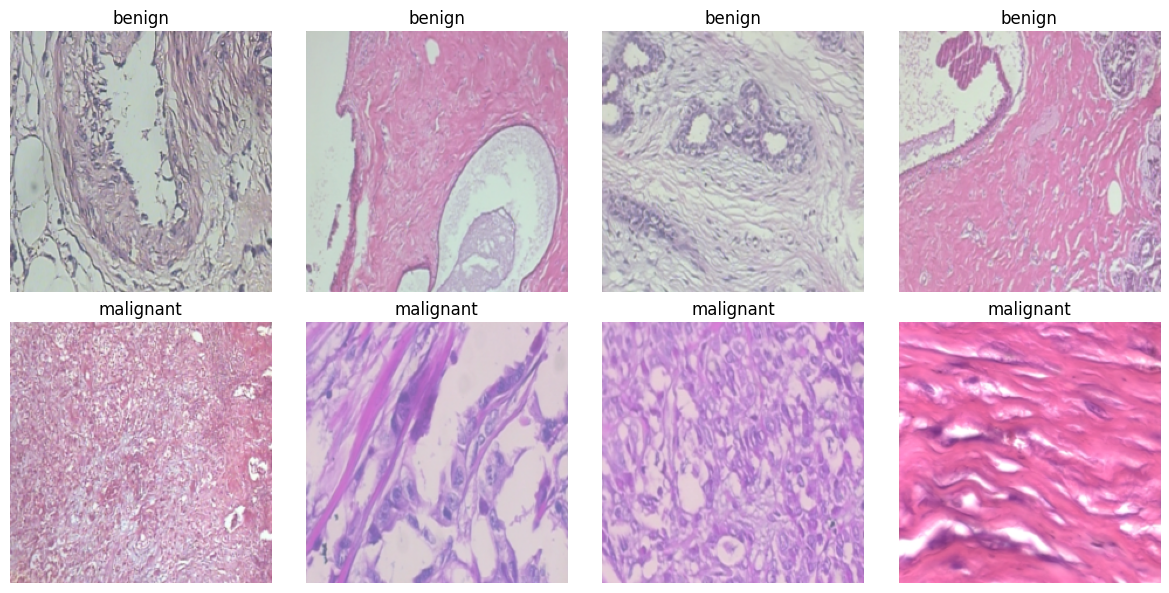

In [5]:
# Data Paths
DATA_DIR = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/'

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load Dataset
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform_train)

# Train/Test Split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Replace transform for test set
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Preview Sample Images
classes = full_dataset.classes
def imshow(img, title=None):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.clamp(0, 1)
    plt.imshow(img.permute(1, 2, 0))
    if title:
        plt.title(title)
    plt.axis('off')

# Show a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    imshow(images[i], title=classes[labels[i]])
plt.tight_layout()
plt.show()


### Model Initialization (ResNet-18 and VGG-16)

In [6]:
import torch.nn as nn
import torchvision.models as models
import torch

# Function to initialize and modify model
def prepare_model(model_name, num_classes=2):
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("Only 'resnet18' and 'vgg16' are supported.")
    
    for param in model.parameters():
        param.requires_grad = True  # Enable full fine-tuning
    return model

# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = prepare_model('resnet18').to(device)
vgg_model = prepare_model('vgg16').to(device)

# Print model summaries
print("ResNet-18 Summary:")
print(resnet_model)

print("\nVGG-16 Summary:")
print(vgg_model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

ResNet-18 Summary:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

### Baseline Training with Clean Histopathology Data Only

In [7]:
import torch.optim as optim
from tqdm import tqdm

# Define training and evaluation functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


### Train ResNet-18 and VGG-16 on Clean Data

In [8]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()

# For ResNet
resnet = prepare_model('resnet18').to(device)
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.0001)

# For VGG
vgg = prepare_model('vgg16').to(device)
optimizer_vgg = optim.Adam(vgg.parameters(), lr=0.0001)

# Containers to track performance
num_epochs = 1
resnet_history = {'train_acc': [], 'val_acc': []}
vgg_history = {'train_acc': [], 'val_acc': []}

# Train ResNet
print("Training ResNet-18...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(resnet, train_loader, criterion, optimizer_resnet, device)
    val_loss, val_acc = evaluate(resnet, test_loader, criterion, device)
    resnet_history['train_acc'].append(train_acc)
    resnet_history['val_acc'].append(val_acc)
    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

# Train VGG
print("\nTraining VGG-16...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(vgg, train_loader, criterion, optimizer_vgg, device)
    val_loss, val_acc = evaluate(vgg, test_loader, criterion, device)
    vgg_history['train_acc'].append(train_acc)
    vgg_history['val_acc'].append(val_acc)
    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Training ResNet-18...


100%|██████████| 198/198 [02:33<00:00,  1.29it/s]


[Epoch 1] Train Acc: 0.9123 | Val Acc: 0.9589

Training VGG-16...


100%|██████████| 198/198 [02:21<00:00,  1.40it/s]


[Epoch 1] Train Acc: 0.8775 | Val Acc: 0.9071


### Evaluating VGG and ResNet performances on clean test histopathology datasets

In [9]:
import pandas as pd

# Evaluate ResNet-18 on clean test set
resnet_test_loss, resnet_test_acc = evaluate(resnet, test_loader, criterion, device)
print(f"\n[ResNet-18] Clean Test Accuracy: {resnet_test_acc:.4f} | Test Loss: {resnet_test_loss:.4f}")

# Evaluate VGG-16 on clean test set
vgg_test_loss, vgg_test_acc = evaluate(vgg, test_loader, criterion, device)
print(f"[VGG-16] Clean Test Accuracy: {vgg_test_acc:.4f} | Test Loss: {vgg_test_loss:.4f}")

results_df = pd.DataFrame({
    "Model": ["ResNet-18", "VGG-16"],
    "Test Accuracy": [resnet_test_acc, vgg_test_acc],
    "Test Loss": [resnet_test_loss, vgg_test_loss]
})

display(results_df)


[ResNet-18] Clean Test Accuracy: 0.9589 | Test Loss: 0.1105
[VGG-16] Clean Test Accuracy: 0.9071 | Test Loss: 0.2176


,Model,Test Accuracy,Test Loss
0,ResNet-18,0.958913,0.110538
1,VGG-16,0.907080,0.217585


## Adversarial Attack with DeepFool

* #### Generating DeepFool adversarial attacked images

In [10]:
!pip install foolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.7 MB/s eta 0:00:0000:010:01


In [11]:
import foolbox as fb
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader

# Manual normalization wrapper
class NormalizeWrapper(nn.Module):
    def __init__(self, model, mean, std):
        super().__init__()
        self.model = model
        self.mean = torch.tensor(mean).view(1, 3, 1, 1).to(device)
        self.std = torch.tensor(std).view(1, 3, 1, 1).to(device)

    def forward(self, x):
        x = (x - self.mean) / self.std
        return self.model(x)

# Wrap model for foolbox (no preprocessing argument)
def get_foolbox_model(model):
    wrapped_model = NormalizeWrapper(model, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return fb.PyTorchModel(wrapped_model, bounds=(0, 1))

def unnormalize(imgs, mean, std):
    mean = torch.tensor(mean).reshape(1, 3, 1, 1).to(imgs.device)
    std = torch.tensor(std).reshape(1, 3, 1, 1).to(imgs.device)
    return imgs * std + mean

def generate_deepfool_examples(model, dataloader, max_samples=1000):
    fmodel = get_foolbox_model(model)
    attack = fb.attacks.L2DeepFoolAttack()
    adv_images, labels = [], []

    for i, (inputs, targets) in enumerate(dataloader):
        if len(adv_images) >= max_samples:
            break

        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs[:10]
        targets = targets[:10]

        # Foolbox expects unnormalized [0,1] inputs
        inputs_raw = unnormalize(inputs, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).clamp(0, 1)

        # Run the attack
        # Extract just the adversarial tensor
        adversarials = attack(fmodel, inputs_raw, targets, epsilons=None)
        if isinstance(adversarials, tuple):
            adversarials = adversarials[0]

        adversarials = adversarials.clamp(0, 1)

        # Re-normalize for PyTorch retraining
        with torch.no_grad():
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
            adversarials_norm = (adversarials - mean) / std
            successful = (model(adversarials_norm).argmax(1) != targets).cpu()

        adv_images.extend(adversarials_norm[successful].detach().cpu())
        labels.extend(targets[successful].detach().cpu())

    return torch.stack(adv_images), torch.tensor(labels)



# Generate adversarial dataset from clean-trained ResNet model
print("Generating DeepFool Histopathology adversarial Images...")
resnet_clean = prepare_model('resnet18').to(device)
resnet_clean.load_state_dict(resnet.state_dict())  # Use weights from clean model
adv_imgs, adv_labels = generate_deepfool_examples(resnet_clean, train_loader, max_samples=3000)

# Combine with original training data
clean_imgs, clean_labels = next(iter(DataLoader(train_dataset, batch_size=len(train_dataset))))
combined_imgs = torch.cat([clean_imgs, adv_imgs], dim=0)
combined_labels = torch.cat([clean_labels, adv_labels], dim=0)

deepfool_train_dataset = TensorDataset(combined_imgs, combined_labels)
deepfool_train_loader = DataLoader(deepfool_train_dataset, batch_size=32, shuffle=True)


Generating DeepFool adversarial examples...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


### Visualizing generated deepfool attacked histopathology images

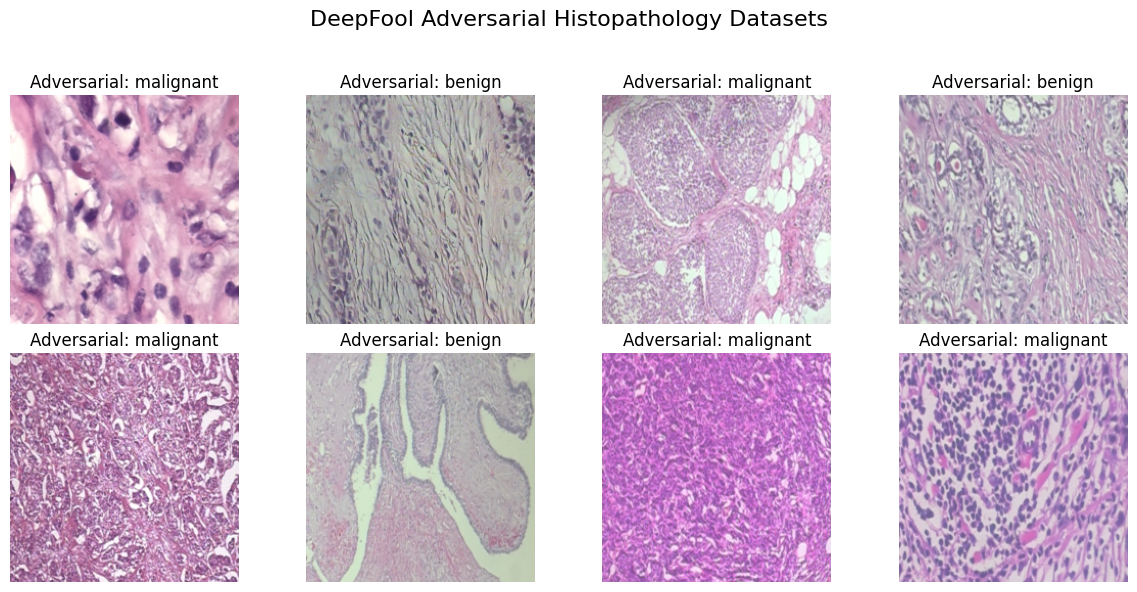

In [12]:
# Helper to denormalize and display image
def imshow(img_tensor, title=None):
    img = img_tensor.clone().detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img * std + mean
    img = img.clamp(0, 1)
    npimg = img.permute(1, 2, 0).numpy()
    plt.imshow(npimg)
    if title:
        plt.title(title)
    plt.axis('off')

# Visualize a few adversarial images
classes = full_dataset.classes
num_samples = min(8, len(adv_imgs))

plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 4, i+1)
    label = classes[adv_labels[i]]
    imshow(adv_imgs[i], title=f"Adversarial: {label}")
plt.suptitle("DeepFool Adversarial Histopathology Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Testing performance of models trained on clean models using deepfool images

In [13]:
from torch.utils.data import TensorDataset, DataLoader

# Ensure DeepFool adversarial samples are available
if 'adv_imgs' not in globals() or 'adv_labels' not in globals():
    adv_imgs, adv_labels = torch.load("deepfool_adversarials.pt")

# Create DataLoader from DeepFool adversarial examples
deepfool_test_dataset = TensorDataset(adv_imgs, adv_labels)
deepfool_test_loader = DataLoader(deepfool_test_dataset, batch_size=32, shuffle=False)

# Evaluate clean-trained ResNet-18 on DeepFool examples
resnet_df_attack_loss, resnet_df_attack_acc = evaluate(resnet, deepfool_test_loader, criterion, device)
print(f"\n[ResNet-18 Clean Model] Accuracy on DeepFool Images: {resnet_df_attack_acc:.4f} | Loss: {resnet_df_attack_loss:.4f}")

# Evaluate clean-trained VGG-16 on DeepFool examples
vgg_df_attack_loss, vgg_df_attack_acc = evaluate(vgg, deepfool_test_loader, criterion, device)
print(f"[VGG-16 Clean Model] Accuracy on DeepFool Images: {vgg_df_attack_acc:.4f} | Loss: {vgg_df_attack_loss:.4f}")

df_attack_results = pd.DataFrame({
    "Model": ["ResNet-18 (clean)", "VGG-16 (clean)"],
    "Accuracy on DeepFool Images": [resnet_df_attack_acc, vgg_df_attack_acc],
    "Loss on DeepFool Images": [resnet_df_attack_loss, vgg_df_attack_loss]
})

display(df_attack_results)



[ResNet-18 Clean Model] Accuracy on DeepFool Images: 0.4413 | Loss: 1.8429
[VGG-16 Clean Model] Accuracy on DeepFool Images: 0.9102 | Loss: 0.2120


,Model,Accuracy on DeepFool Images,Loss on DeepFool Images
0,ResNet-18 (clean),0.441253,1.842921
1,VGG-16 (clean),0.910183,0.211983


* #### Retraining ResNet-18 and VGG-16 using the augmented dataset

In [14]:
# Reinitialize models
resnet_df = prepare_model('resnet18').to(device)
vgg_df = prepare_model('vgg16').to(device)

optimizer_resnet_df = optim.Adam(resnet_df.parameters(), lr=0.0001)
optimizer_vgg_df = optim.Adam(vgg_df.parameters(), lr=0.0001)

df_history = {"resnet": {"train_acc": [], "val_acc": []}, "vgg": {"train_acc": [], "val_acc": []}}

print("Retraining ResNet-18 on DeepFool data...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(resnet_df, deepfool_train_loader, criterion, optimizer_resnet_df, device)
    val_loss, val_acc = evaluate(resnet_df, test_loader, criterion, device)
    df_history["resnet"]["train_acc"].append(train_acc)
    df_history["resnet"]["val_acc"].append(val_acc)
    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

print("\nRetraining VGG-16 on DeepFool data...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(vgg_df, deepfool_train_loader, criterion, optimizer_vgg_df, device)
    val_loss, val_acc = evaluate(vgg_df, test_loader, criterion, device)
    df_history["vgg"]["train_acc"].append(train_acc)
    df_history["vgg"]["val_acc"].append(val_acc)
    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
 

Retraining ResNet-18 on DeepFool data...


100%|██████████| 258/258 [00:15<00:00, 16.80it/s]


[Epoch 1] Train Acc: 0.9177 | Val Acc: 0.9501

Retraining VGG-16 on DeepFool data...


100%|██████████| 258/258 [01:05<00:00,  3.94it/s]


[Epoch 1] Train Acc: 0.8794 | Val Acc: 0.9153


### Evaluate DeepFool-Trained Models on Clean Test Set

In [15]:
# Evaluate DeepFool-trained ResNet-18 on clean test set
resnet_df_clean_loss, resnet_df_clean_acc = evaluate(resnet_df, test_loader, criterion, device)
print(f"\n[ResNet-18 + DeepFool Training] Accuracy on Clean Test Set: {resnet_df_clean_acc:.4f} | Loss: {resnet_df_clean_loss:.4f}")

# Evaluate DeepFool-trained VGG-16 on clean test set
vgg_df_clean_loss, vgg_df_clean_acc = evaluate(vgg_df, test_loader, criterion, device)
print(f"[VGG-16 + DeepFool Training] Accuracy on Clean Test Set: {vgg_df_clean_acc:.4f} | Loss: {vgg_df_clean_loss:.4f}")

df_clean_test_results = pd.DataFrame({
    "Model": ["ResNet-18 (DF-trained)", "VGG-16 (DF-trained)"],
    "Accuracy on Clean Test": [resnet_df_clean_acc, vgg_df_clean_acc],
    "Loss on Clean Test": [resnet_df_clean_loss, vgg_df_clean_loss]
})

display(df_clean_test_results)



[ResNet-18 + DeepFool Training] Accuracy on Clean Test Set: 0.9501 | Loss: 0.1320
[VGG-16 + DeepFool Training] Accuracy on Clean Test Set: 0.9153 | Loss: 0.2221


,Model,Accuracy on Clean Test,Loss on Clean Test
0,ResNet-18 (DF-trained),0.950063,0.132033
1,VGG-16 (DF-trained),0.915297,0.222105


### Evaluate these models on DeepFool-attacked test images

* Generate DeepFool Attacks from Clean Test Set

In [16]:
# Wrap DeepFool-trained model (ResNet used for attack)
resnet_for_attack = prepare_model('resnet18').to(device)
resnet_for_attack.load_state_dict(resnet_df.state_dict())
resnet_for_attack.eval()

# Generate DeepFool adversarial examples from the test set
print("Generating DeepFool test set for Histopathology images...")
test_adv_imgs, test_adv_labels = generate_deepfool_examples(resnet_for_attack, test_loader, max_samples=1000)

# Save for later reuse (optional)
torch.save((test_adv_imgs, test_adv_labels), "deepfool_test_adversarials.pt")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


Generating DeepFool test set examples...


* Create DataLoader for DeepFool Test Images

In [17]:
from torch.utils.data import TensorDataset, DataLoader

deepfool_testset = TensorDataset(test_adv_imgs, test_adv_labels)
deepfool_test_loader = DataLoader(deepfool_testset, batch_size=32, shuffle=False)


* Evaluate DeepFool-Trained Models on DeepFool-Attacked Test Set

In [18]:
# ResNet-18 trained on DeepFool, evaluated on DeepFool test images
resnet_df_attack_loss, resnet_df_attack_acc = evaluate(resnet_df, deepfool_test_loader, criterion, device)
print(f"\n[ResNet-18 DF-trained] Accuracy on DeepFool Test Images: {resnet_df_attack_acc:.4f} | Loss: {resnet_df_attack_loss:.4f}")

# VGG-16 trained on DeepFool, evaluated on DeepFool test images
vgg_df_attack_loss, vgg_df_attack_acc = evaluate(vgg_df, deepfool_test_loader, criterion, device)
print(f"[VGG-16 DF-trained] Accuracy on DeepFool Test Images: {vgg_df_attack_acc:.4f} | Loss: {vgg_df_attack_loss:.4f}")

df_df_test_results = pd.DataFrame({
    "Model": ["ResNet-18 (DF-trained)", "VGG-16 (DF-trained)"],
    "Accuracy on DeepFool Test": [resnet_df_attack_acc, vgg_df_attack_acc],
    "Loss on DeepFool Test": [resnet_df_attack_loss, vgg_df_attack_loss]
})

display(df_df_test_results)



[ResNet-18 DF-trained] Accuracy on DeepFool Test Images: 0.0000 | Loss: 0.7518
[VGG-16 DF-trained] Accuracy on DeepFool Test Images: 0.9200 | Loss: 0.2000


,Model,Accuracy on DeepFool Test,Loss on DeepFool Test
0,ResNet-18 (DF-trained),0.00,0.751833
1,VGG-16 (DF-trained),0.92,0.199952


### Adversarial Training with PGD


In [19]:
!pip install torchattacks


#### Generate Projected Gradient Descent (PGD) Training Examples

In [20]:
import torchattacks

# Generate PGD adversarial examples from training set
def generate_pgd_examples(model, dataloader, max_samples=3000, epsilon=0.03, alpha=0.007, steps=40):
    atk = torchattacks.PGD(model, eps=epsilon, alpha=alpha, steps=steps)
    model.eval()
    adv_imgs, labels = [], []

    for i, (inputs, targets) in enumerate(dataloader):
        if len(adv_imgs) >= max_samples:
            break
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs[:10]
        targets = targets[:10]
        adv = atk(inputs, targets)
        adv_imgs.extend(adv.detach().cpu())
        labels.extend(targets.detach().cpu())

    return torch.stack(adv_imgs), torch.tensor(labels)


#### Generate PGD Training Data & Train

In [21]:
# Use clean-trained ResNet for PGD generation
resnet_clean_for_pgd = prepare_model('resnet18').to(device)
resnet_clean_for_pgd.load_state_dict(resnet.state_dict())

print("Generating PGD adversarial Histopathology images for training...")
pgd_imgs, pgd_labels = generate_pgd_examples(resnet_clean_for_pgd, train_loader, max_samples=3000)

# Combine with clean training set
clean_imgs, clean_labels = next(iter(DataLoader(train_dataset, batch_size=len(train_dataset))))
combined_imgs_pgd = torch.cat([clean_imgs, pgd_imgs], dim=0)
combined_labels_pgd = torch.cat([clean_labels, pgd_labels], dim=0)

pgd_train_dataset = TensorDataset(combined_imgs_pgd, combined_labels_pgd)
pgd_train_loader = DataLoader(pgd_train_dataset, batch_size=32, shuffle=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generating PGD adversarial examples for training...


### Retrain Models on PGD-Augmented Data

In [22]:
# Initialize models
resnet_pgd = prepare_model('resnet18').to(device)
vgg_pgd = prepare_model('vgg16').to(device)

optimizer_resnet_pgd = optim.Adam(resnet_pgd.parameters(), lr=0.0001)
optimizer_vgg_pgd = optim.Adam(vgg_pgd.parameters(), lr=0.0001)

print("Training ResNet-18 on PGD data...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(resnet_pgd, pgd_train_loader, criterion, optimizer_resnet_pgd, device)
    val_loss, val_acc = evaluate(resnet_pgd, test_loader, criterion, device)
    print(f"[ResNet Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

print("\nTraining VGG-16 on PGD data...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(vgg_pgd, pgd_train_loader, criterion, optimizer_vgg_pgd, device)
    val_loss, val_acc = evaluate(vgg_pgd, test_loader, criterion, device)
    print(f"[VGG Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training ResNet-18 on PGD data...


100%|██████████| 260/260 [00:15<00:00, 16.85it/s]


[ResNet Epoch 1] Train Acc: 0.9116 | Val Acc: 0.9614

Training VGG-16 on PGD data...


100%|██████████| 260/260 [01:06<00:00,  3.94it/s]


[VGG Epoch 1] Train Acc: 0.8549 | Val Acc: 0.8780


### Evaluate on Clean Test Set

In [23]:
resnet_pgd_clean_loss, resnet_pgd_clean_acc = evaluate(resnet_pgd, test_loader, criterion, device)
vgg_pgd_clean_loss, vgg_pgd_clean_acc = evaluate(vgg_pgd, test_loader, criterion, device)

print(f"\n[ResNet-18 PGD-trained] Clean Test Acc: {resnet_pgd_clean_acc:.4f} | Loss: {resnet_pgd_clean_loss:.4f}")
print(f"[VGG-16 PGD-trained] Clean Test Acc: {vgg_pgd_clean_acc:.4f} | Loss: {vgg_pgd_clean_loss:.4f}")



[ResNet-18 PGD-trained] Clean Test Acc: 0.9614 | Loss: 0.1047
[VGG-16 PGD-trained] Clean Test Acc: 0.8780 | Loss: 0.2657


### Evaluate on PGD-Attacked Test Set

In [24]:
# Generate PGD from test set
print("Generating PGD adversarial test Images...")
pgd_test_imgs, pgd_test_labels = generate_pgd_examples(resnet_pgd, test_loader, max_samples=1000)
pgd_test_loader = DataLoader(TensorDataset(pgd_test_imgs, pgd_test_labels), batch_size=32, shuffle=False)

resnet_pgd_adv_loss, resnet_pgd_adv_acc = evaluate(resnet_pgd, pgd_test_loader, criterion, device)
vgg_pgd_adv_loss, vgg_pgd_adv_acc = evaluate(vgg_pgd, pgd_test_loader, criterion, device)

print(f"\n[ResNet-18 PGD-trained] PGD Test Acc: {resnet_pgd_adv_acc:.4f} | Loss: {resnet_pgd_adv_loss:.4f}")
print(f"[VGG-16 PGD-trained] PGD Test Acc: {vgg_pgd_adv_acc:.4f} | Loss: {vgg_pgd_adv_loss:.4f}")


Generating PGD adversarial test examples...

[ResNet-18 PGD-trained] PGD Test Acc: 0.0000 | Loss: 20.1316
[VGG-16 PGD-trained] PGD Test Acc: 0.8260 | Loss: 0.4132


### Visualize PGD Adversarial Examples

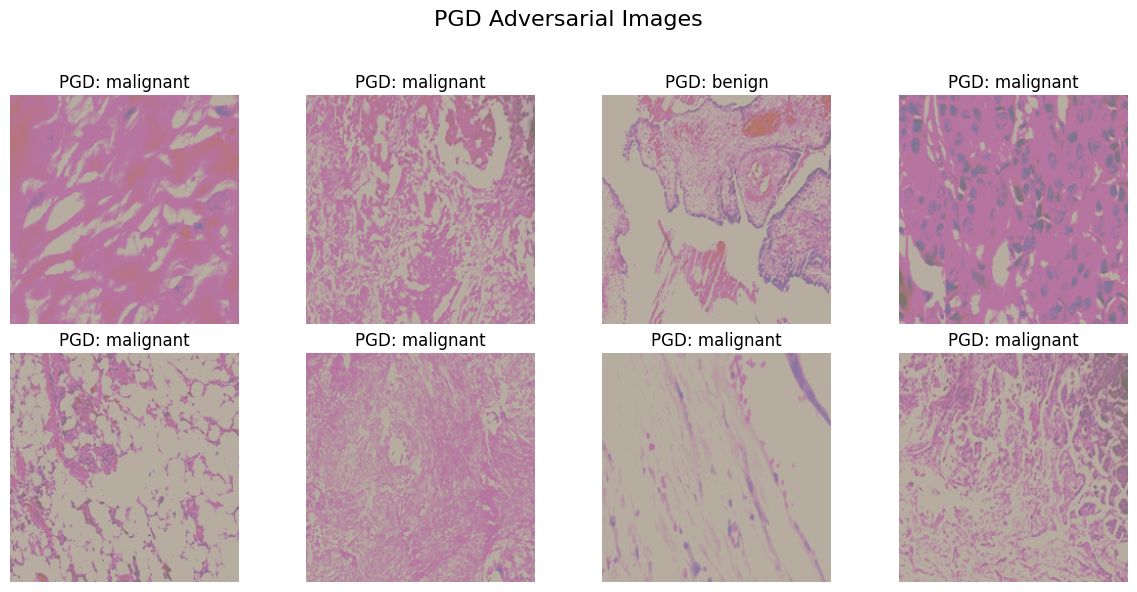

In [27]:
plt.figure(figsize=(12, 6))
for i in range(min(8, len(pgd_test_imgs))):
    plt.subplot(2, 4, i+1)
    label = full_dataset.classes[pgd_test_labels[i]]
    imshow(pgd_test_imgs[i], title=f"PGD: {label}")
plt.suptitle("PGD Adversarial Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Multi-Modal Defense (PGD Adversarial Training + Feature Squeezing)

### Define Feature Squeezing (4-bit Reduction)

In [28]:
# Feature Squeezing: Reduce to 4-bit depth
def feature_squeeze(images, bit_depth=4):
    levels = 2 ** bit_depth
    return torch.round(images * (levels - 1)) / (levels - 1)


### Evaluate PGD-Trained Models with Feature Squeezing

In [29]:
# Evaluate ResNet-18 PGD-trained + feature squeezing on clean test set
def evaluate_with_squeezing(model, dataloader, criterion, device, bit_depth=4):
    model.eval()
    correct, total, total_loss = 0, 0, 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = feature_squeeze(inputs, bit_depth)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    return total_loss / total, correct / total


### Evaluate on Clean Test Set (with squeezing)

In [30]:
resnet_pgd_squeezed_loss, resnet_pgd_squeezed_acc = evaluate_with_squeezing(resnet_pgd, test_loader, criterion, device)
vgg_pgd_squeezed_loss, vgg_pgd_squeezed_acc = evaluate_with_squeezing(vgg_pgd, test_loader, criterion, device)

print(f"\n[ResNet-18 PGD-trained + Squeezing] Clean Test Acc: {resnet_pgd_squeezed_acc:.4f} | Loss: {resnet_pgd_squeezed_loss:.4f}")
print(f"[VGG-16 PGD-trained + Squeezing] Clean Test Acc: {vgg_pgd_squeezed_acc:.4f} | Loss: {vgg_pgd_squeezed_loss:.4f}")



[ResNet-18 PGD-trained + Squeezing] Clean Test Acc: 0.9608 | Loss: 0.1066
[VGG-16 PGD-trained + Squeezing] Clean Test Acc: 0.8774 | Loss: 0.2704


### Evaluate on PGD-Attacked Test Set (with squeezing)

In [31]:
resnet_pgd_adv_squeezed_loss, resnet_pgd_adv_squeezed_acc = evaluate_with_squeezing(resnet_pgd, pgd_test_loader, criterion, device)
vgg_pgd_adv_squeezed_loss, vgg_pgd_adv_squeezed_acc = evaluate_with_squeezing(vgg_pgd, pgd_test_loader, criterion, device)

print(f"\n[ResNet-18 PGD-trained + Squeezing] PGD Test Acc: {resnet_pgd_adv_squeezed_acc:.4f} | Loss: {resnet_pgd_adv_squeezed_loss:.4f}")
print(f"[VGG-16 PGD-trained + Squeezing] PGD Test Acc: {vgg_pgd_adv_squeezed_acc:.4f} | Loss: {vgg_pgd_adv_squeezed_loss:.4f}")

df_multi_defense = pd.DataFrame({
    "Model": ["ResNet-18 PGD+FS", "VGG-16 PGD+FS"],
    "Clean Test Acc": [resnet_pgd_squeezed_acc, vgg_pgd_squeezed_acc],
    "PGD Test Acc": [resnet_pgd_adv_squeezed_acc, vgg_pgd_adv_squeezed_acc]
})

display(df_multi_defense)



[ResNet-18 PGD-trained + Squeezing] PGD Test Acc: 0.0000 | Loss: 19.0347
[VGG-16 PGD-trained + Squeezing] PGD Test Acc: 0.8220 | Loss: 0.4147


,Model,Clean Test Acc,PGD Test Acc
0,ResNet-18 PGD+FS,0.960809,0.000
1,VGG-16 PGD+FS,0.877370,0.822


## DeepFool Adversarial Training + Feature Squeezing
* resnet_df and vgg_df (trained on DeepFool-augmented data),

* with 4-bit feature squeezing applied at evaluation time only.



### Evaluate on Clean Test Set (with Squeezing)

In [32]:
resnet_df_clean_squeezed_loss, resnet_df_clean_squeezed_acc = evaluate_with_squeezing(resnet_df, test_loader, criterion, device)
vgg_df_clean_squeezed_loss, vgg_df_clean_squeezed_acc = evaluate_with_squeezing(vgg_df, test_loader, criterion, device)

print(f"\n[ResNet-18 DF-trained + Squeezing] Clean Test Acc: {resnet_df_clean_squeezed_acc:.4f} | Loss: {resnet_df_clean_squeezed_loss:.4f}")
print(f"[VGG-16 DF-trained + Squeezing] Clean Test Acc: {vgg_df_clean_squeezed_acc:.4f} | Loss: {vgg_df_clean_squeezed_loss:.4f}")



[ResNet-18 DF-trained + Squeezing] Clean Test Acc: 0.9513 | Loss: 0.1313
[VGG-16 DF-trained + Squeezing] Clean Test Acc: 0.9140 | Loss: 0.2172


### Evaluate on DeepFool-Attacked Test Set (with Squeezing)

In [33]:
resnet_df_clean_squeezed_loss, resnet_df_clean_squeezed_acc = evaluate_with_squeezing(resnet_df, test_loader, criterion, device)
vgg_df_clean_squeezed_loss, vgg_df_clean_squeezed_acc = evaluate_with_squeezing(vgg_df, test_loader, criterion, device)

print(f"\n[ResNet-18 DF-trained + Squeezing] Clean Test Acc: {resnet_df_clean_squeezed_acc:.4f} | Loss: {resnet_df_clean_squeezed_loss:.4f}")
print(f"[VGG-16 DF-trained + Squeezing] Clean Test Acc: {vgg_df_clean_squeezed_acc:.4f} | Loss: {vgg_df_clean_squeezed_loss:.4f}")



[ResNet-18 DF-trained + Squeezing] Clean Test Acc: 0.9513 | Loss: 0.1313
[VGG-16 DF-trained + Squeezing] Clean Test Acc: 0.9140 | Loss: 0.2172


### Evaluate on DeepFool-Attacked Test Set (with Squeezing)

In [34]:
resnet_df_adv_squeezed_loss, resnet_df_adv_squeezed_acc = evaluate_with_squeezing(resnet_df, deepfool_test_loader, criterion, device)
vgg_df_adv_squeezed_loss, vgg_df_adv_squeezed_acc = evaluate_with_squeezing(vgg_df, deepfool_test_loader, criterion, device)

print(f"\n[ResNet-18 DF-trained + Squeezing] DeepFool Test Acc: {resnet_df_adv_squeezed_acc:.4f} | Loss: {resnet_df_adv_squeezed_loss:.4f}")
print(f"[VGG-16 DF-trained + Squeezing] DeepFool Test Acc: {vgg_df_adv_squeezed_acc:.4f} | Loss: {vgg_df_adv_squeezed_loss:.4f}")

df_multi_defense_df = pd.DataFrame({
    "Model": ["ResNet-18 DF+FS", "VGG-16 DF+FS"],
    "Clean Test Acc": [resnet_df_clean_squeezed_acc, vgg_df_clean_squeezed_acc],
    "DeepFool Test Acc": [resnet_df_adv_squeezed_acc, vgg_df_adv_squeezed_acc]
})

display(df_multi_defense_df)



[ResNet-18 DF-trained + Squeezing] DeepFool Test Acc: 0.9300 | Loss: 0.6264
[VGG-16 DF-trained + Squeezing] DeepFool Test Acc: 0.9220 | Loss: 0.1955


,Model,Clean Test Acc,DeepFool Test Acc
0,ResNet-18 DF+FS,0.951327,0.930
1,VGG-16 DF+FS,0.914033,0.922


## Result outputs and visualization of results

In [35]:
evaluation_summary = pd.DataFrame({
    "Model": [
        "ResNet-18 (Clean)", "ResNet-18 (DF)", "ResNet-18 (PGD)", "ResNet-18 (PGD+FS)", "ResNet-18 (DF+FS)",
        "VGG-16 (Clean)", "VGG-16 (DF)", "VGG-16 (PGD)", "VGG-16 (PGD+FS)", "VGG-16 (DF+FS)"
    ],
    "Clean Test Acc": [
        resnet_test_acc, resnet_df_clean_acc, resnet_pgd_clean_acc, resnet_pgd_squeezed_acc, resnet_df_clean_squeezed_acc,
        vgg_test_acc, vgg_df_clean_acc, vgg_pgd_clean_acc, vgg_pgd_squeezed_acc, vgg_df_clean_squeezed_acc
    ],
    "DeepFool Test Acc": [
        resnet_df_attack_acc, resnet_df_attack_acc, np.nan, np.nan, resnet_df_adv_squeezed_acc,
        vgg_df_attack_acc, vgg_df_attack_acc, np.nan, np.nan, vgg_df_adv_squeezed_acc
    ],
    "PGD Test Acc": [
        resnet_pgd_adv_acc, np.nan, resnet_pgd_adv_acc, resnet_pgd_adv_squeezed_acc, np.nan,
        vgg_pgd_adv_acc, np.nan, vgg_pgd_adv_acc, vgg_pgd_adv_squeezed_acc, np.nan
    ]
})

display(evaluation_summary)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Model,Clean Test Acc,DeepFool Test Acc,PGD Test Acc
0,ResNet-18 (Clean),0.958913,0.000,0.000
1,ResNet-18 (DF),0.950063,0.000,NaN
2,ResNet-18 (PGD),0.961441,NaN,0.000
3,ResNet-18 (PGD+FS),0.960809,NaN,0.000
4,ResNet-18 (DF+FS),0.951327,0.930,NaN
5,VGG-16 (Clean),0.907080,0.920,0.826
6,VGG-16 (DF),0.915297,0.920,NaN
7,VGG-16 (PGD),0.878003,NaN,0.826
8,VGG-16 (PGD+FS),0.877370,NaN,0.822
9,VGG-16 (DF+FS),0.914033,0.922,NaN


### Bar Plot: Clean vs. Attacked Accuracy Comparison

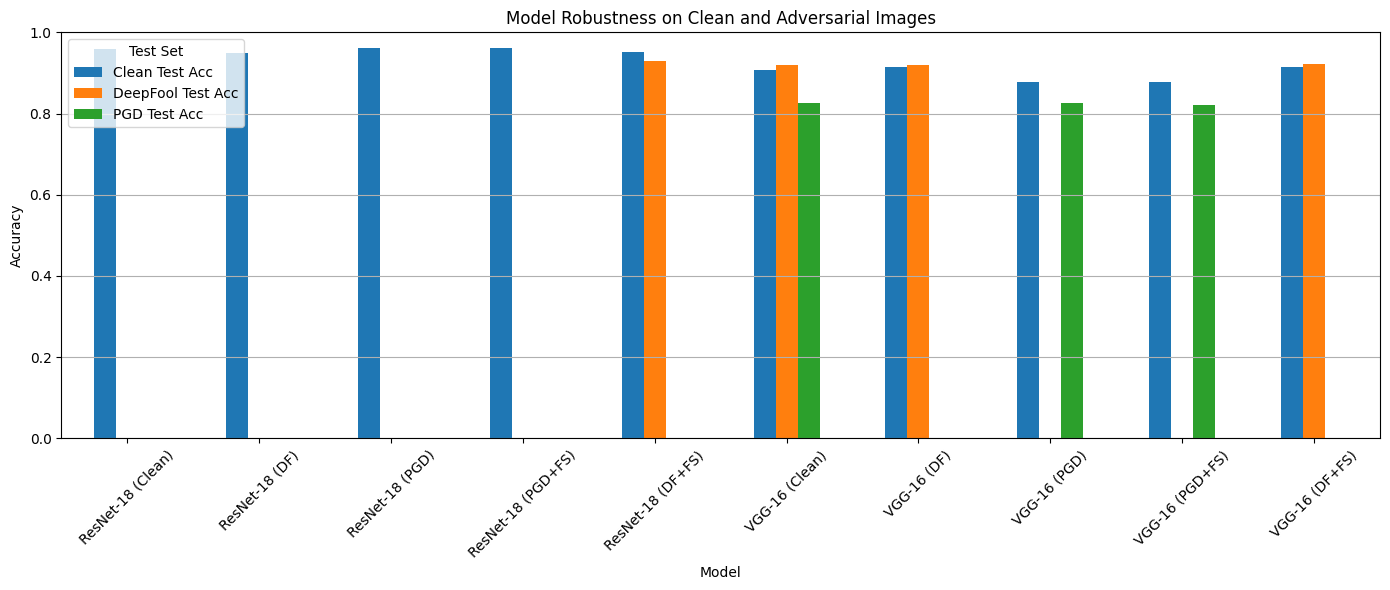

In [36]:
import matplotlib.pyplot as plt

# Reshape for grouped barplot
plot_df = evaluation_summary.set_index("Model")[["Clean Test Acc", "DeepFool Test Acc", "PGD Test Acc"]]

# Plot
plot_df.plot(kind="bar", figsize=(14, 6), rot=45)
plt.title("Model Robustness on Clean and Adversarial Images")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.legend(title="Test Set")
plt.show()
